# SpaMTP: Pig Fetus Vignette


This package highlights the utility of *SpaMTP* on Spatial Metabolomic data. This vignette will use a publically avaible pig fetus cross-section sample, which was generated using DESI-MSI (https://www.nature.com/articles/s41598-019-43698-2). 


Using *SpaMTP* we will highlight:
1. Data Pre-Processing and Normalisation
2. Converting a *Cardinal* object to SpaMTP
3. Mass-to-Charge ratio Annotation
4. Downstream analysis including differential marker expression, PCA and pathway analysis
5. Data Visualisation 

## 1. Data Pre-Processing and Normalisation

Here we will load in the pig fetus public dataset. We will use Cardinal to load this to show the easy transition between the two packages

First we need to import the required libraries for this analysis 

#### Install and Import *R* Libraries

In [ ]:
## Install SpaMTP if not previously installed
#devtools::install_github("BiomedicalMachineLearning/SpaMTP")library(SpaMTP)

# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("CardinalWorkflows")

In [1]:
#General Libraries
library(Cardinal)
library(CardinalWorkflows)
library(Seurat)
library(SpaMTP)

#For plotting + DE plots
library(ggplot2)
#library(EnhancedVolcano)

#For Correlation Analysis
#library(Hmisc)
#library(corrplot)
#library(cowplot)

#For Deconvolution Analysis
#library(CARD)
#library(MuSiC)

Loading required package: ProtGenerics


Attaching package: ‘ProtGenerics’


The following object is masked from ‘package:stats’:

    smooth


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: BiocParallel

Loading required package: EBImage

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

  

#### Load *SM* Data

Lets load the data as a *Cardinal* object

In [4]:
data(pig206, package="CardinalWorkflows")

pig_cardinal <- as(pig206, "MSImagingExperiment")

Now that our data is loaded lets run some processing steps using *Cardinal*! 

First we will generate a plot to visualise our data.

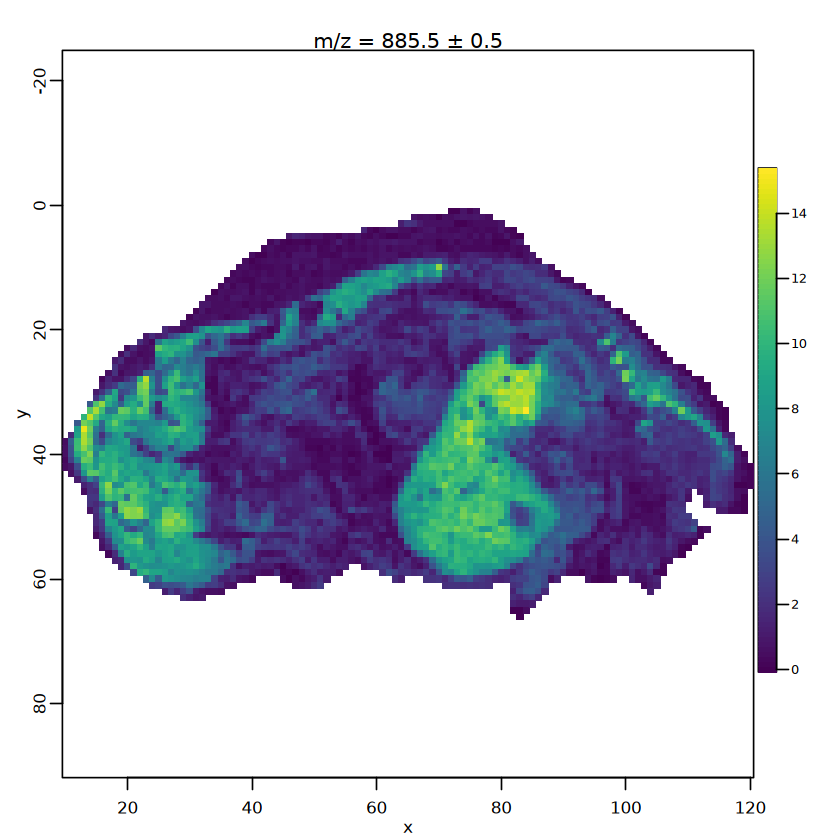

In [5]:
image(pig_cardinal, mz=885.5, plusminus=0.5)

#### Run Sample Pre-Processing using *Cardinal*

Now that we have our data loaded we can run some pre-processing steps using *Carindal* to remove any poor quality pixels or m/z peaks

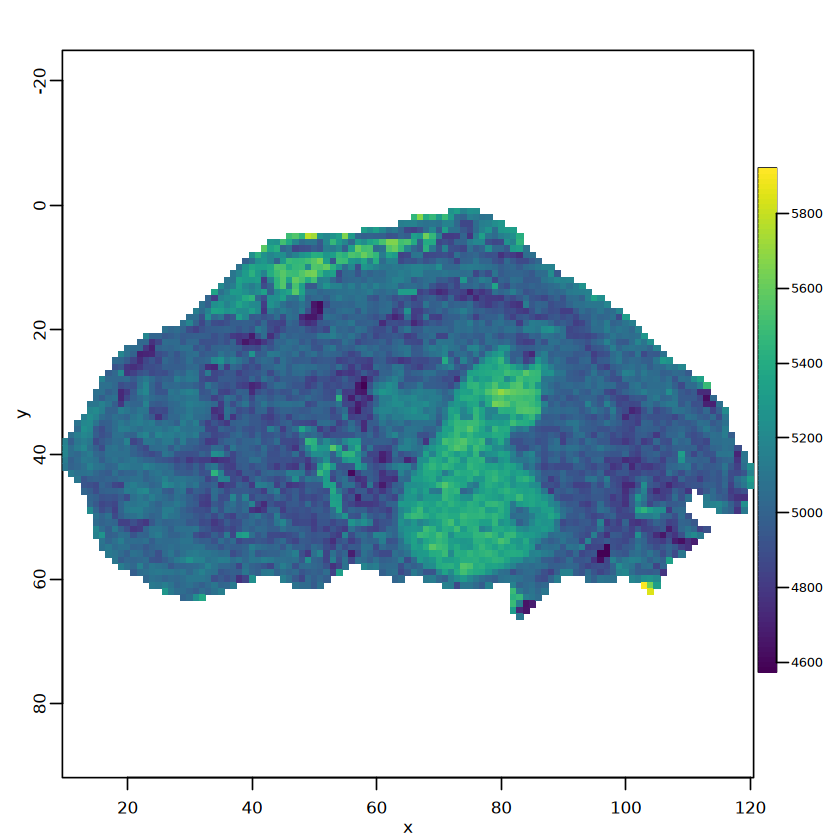

In [6]:
## Summarises the expression of each pixel
pig_tic <- summarizePixels(pig_cardinal, c(tic="sum"))

image(pig_tic)

By calculating the mean pixel we can set some thresholds to remove low quality peaks allowing us to get a more refined object for PCA analysis and SSC segmentation

In [9]:
mean_spec <- summarizeFeatures(pig_cardinal, "mean")

Now that the significant peaks have been selected and binned we can run PCA analysis to define the first 3 PCA's -> we can check if there are any poor quality pixels/pixels outside the tissue region


In [14]:
# Run PCA analysis
pig_pca <- PCA(pig_cardinal, ncomp=3)

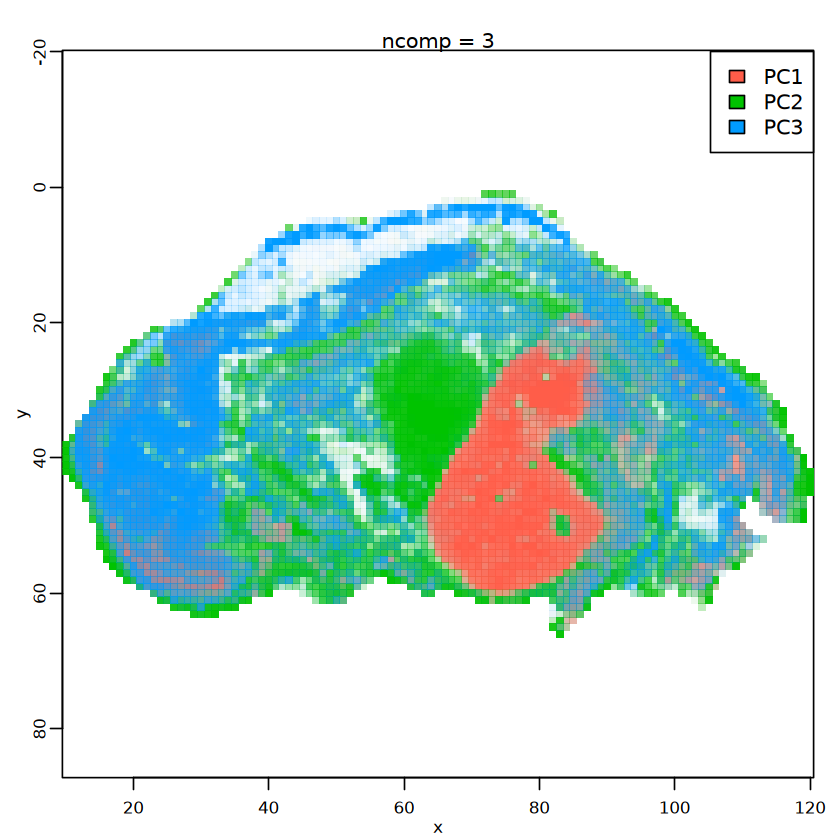

In [15]:
image(pig_pca, contrast.enhance="histogram", normalize.image="linear")

#### Run Segmentation using Spatial Shrunken Centroids in *Cardinal*

We can see that our data is of good quality so lets run segmentation on the object 

In [16]:
pig_ssc <- spatialShrunkenCentroids(pig_cardinal, method="adaptive", 
                                       r=2, s=c(0,5,10,15,20,25,32), k=8)

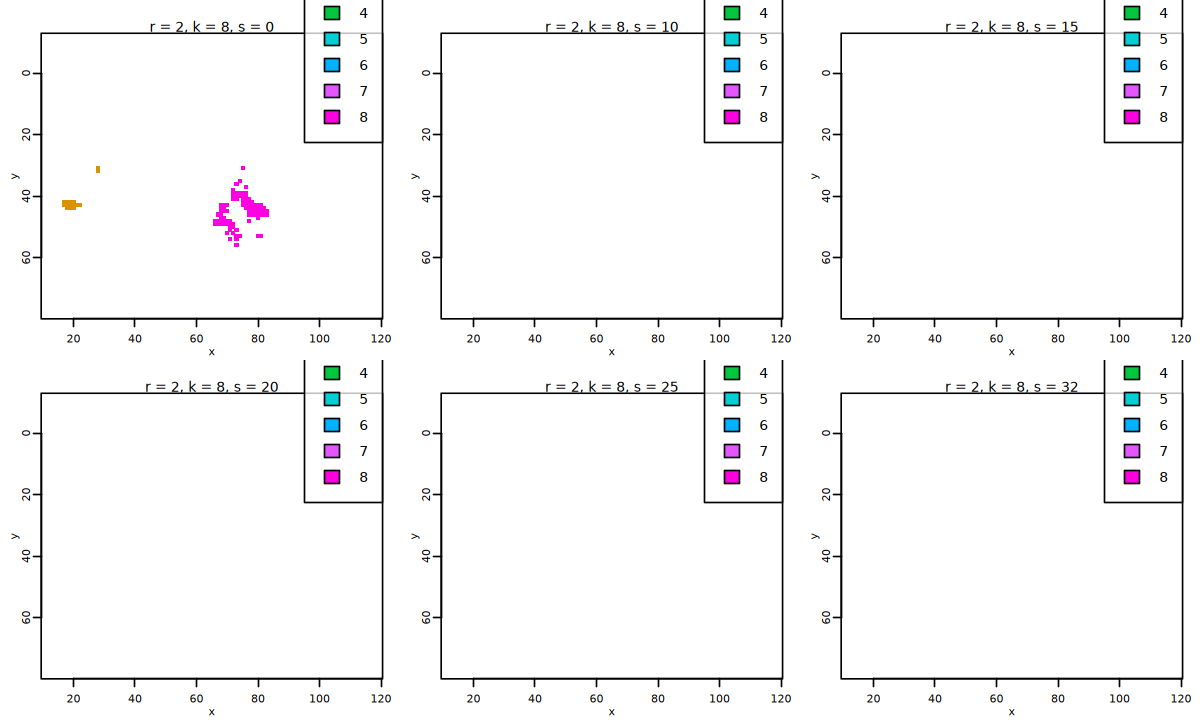

In [17]:
options(repr.plot.width = 10, repr.plot.height = 6) 

image(pig_ssc, model=list(s=c(0, 10,15,20,25,32)))

Based on the results above we will pick a segmentation resolution of 32

## 2. Converting from *Cardinal* to *SpaMTP*

Now that we have our normalised and process dataset, along with our segmentation results we can convert our processed *Cardinal* object into a *SpaMTP Seurat* class object

In [13]:
pig_SpaMTP <- CardinalToSeurat(data = pig_peaks,run_name = "PIGII_206")

Convering Cardinal object to Seurat object .... 

Generating Seurat Barcode Labels from Pixel Coordinates .... 

Constructing Seurat Object ....

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Adding Pixel Metadata ....

Creating Centroids for Spatial Seurat Object ....



Now lets compare the the *SpaMTP* and *Cardinal* objects

In [14]:
pig_peaks

An object of class 'MSContinuousImagingExperiment'
  <110 feature, 4959 pixel> imaging dataset
    imageData(1): intensity
    featureData(0):
    pixelData(0):
    processing complete(2): normalize peakBin
    processing pending(0):
    run(1): PIGII_206
    raster dimensions: 111 x 66
    coord(2): x = 10..120, y = 1..66
    mass range: 157.3966 to 889.6261 
    centroided: TRUE 

In [15]:
pig_SpaMTP

An object of class Seurat 
110 features across 4959 samples within 1 assay 
Active assay: Spatial (110 features, 0 variable features)
 1 layer present: counts
 1 spatial field of view present: fov

We can see that the number of m/z values and the number of pixels is the same between our object. Lets now plot our *SpaMTP* obeject!

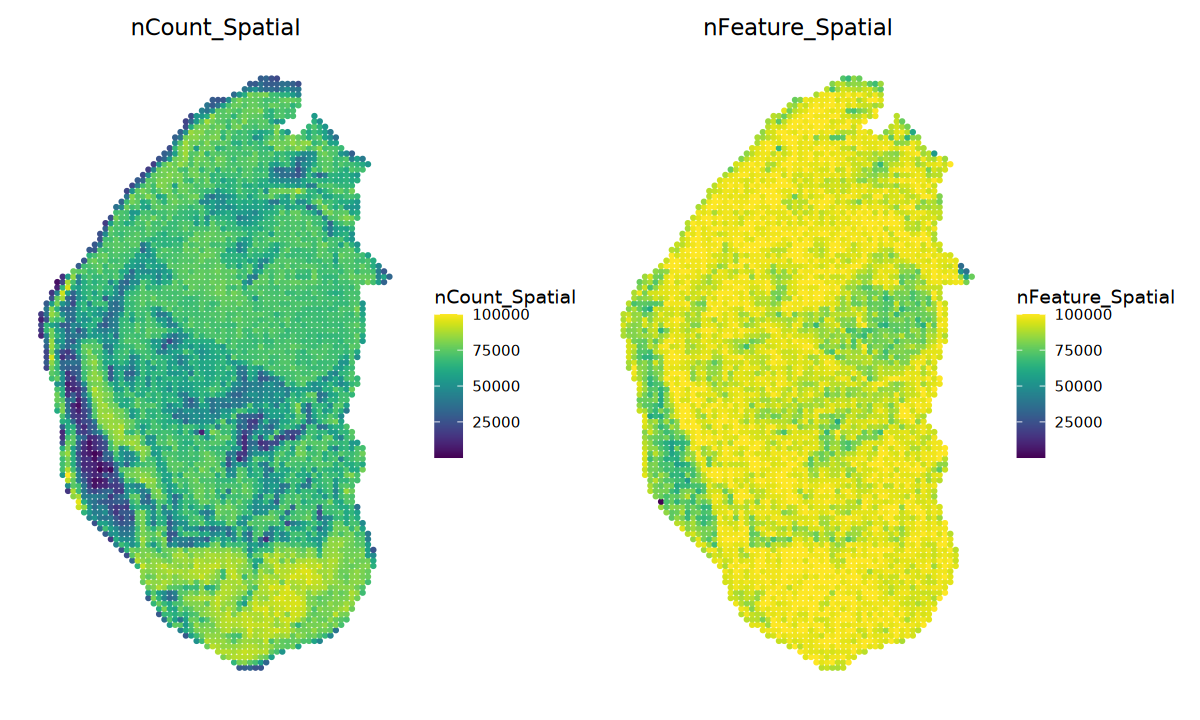

In [16]:
ImageFeaturePlot(pig_SpaMTP, features = c("nCount_Spatial", "nFeature_Spatial"), size = 1.5, dark.background = FALSE, cols = viridis(100000))

We can also add in the clustering/segmentation results generated above

In [17]:
pig_SpaMTP@meta.data$ssc <- resultData(pig_ssc)[[7]]$class

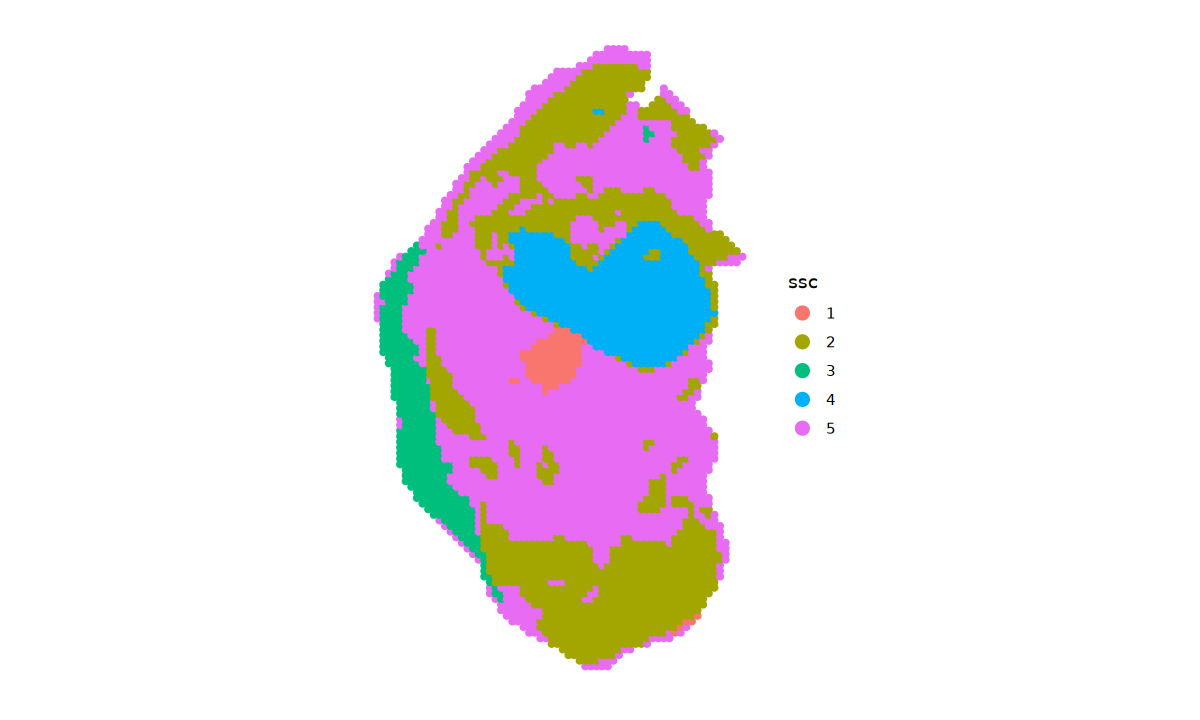

In [18]:
ImageDimPlot(pig_SpaMTP, group.by = "ssc", size = 2, dark.background = FALSE)

## 3. Mass-to-Charge ratio Annotation

Now we can we can perform m/z annotation to find metabolites corresponding to each valid m/z value. 
The database that we will use to annotate the masses is the *Human Metabolite Database* (HMDB_db). For more infomation follow the link (https://hmdb.ca/)

In [19]:
pig_annotated <- AnnotateSeuratMALDI(pig_SpaMTP, HMDB_db, polarity = "neg", ppm_error = 10, return.only.annotated = T)

Filtering 'HMDB_db' database by M+H adduct/s

Searching database against input m/z's to return annotaiton results

Adding annotations to Seurat Object .... 

Warning message:
“Setting row names on a tibble is deprecated.”
Returning Seurat object that include ONLY SUCCESSFULLY ANNOTATED m/z features

Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Seurat objects”


From this we could annotate 22 possible metabolites corresponding to different m/z values

In [20]:
head(pig_annotated@assays$Spatial@meta.data, n = 3) 

,raw_mz,mz_names,observed_mz,all_IsomerNames,all_Isomers
,<dbl>,<chr>,<chr>,<chr>,<chr>
64,385.1470,mz-385.147040763221,385.147040763221,Elafibranor,HMDB0251730
69,509.0931,mz-509.093070502547,509.093070502547,"1,4-Dimethoxyglucobrassicin",HMDB0036986
76,565.1515,mz-565.151450925335,565.151450925335,Apigenin 6-C-glucoside 8-C-arabinoside; Corymboside; Apiin; 6-beta-D-Glucopyranosyl-8-beta-D-ribopyranosylapigenin; Isovitexin 2''-O-arabinoside; Kaempferol 3-arabinofuranoside 7-rhamnofuranoside; Kaempferol 3-rhamnoside 7-xyloside; Kaempferol 3-rhamnoside 4'-xyloside; Apigenin 6-C-arabinoside 8-C-glucoside; Apigenin 6-C-galactoside 8-C-arabinoside; Apigenin 7-apiosyl-glucoside; Apigenin 6-C-glucosyl-O-arabinoside; Vitexin 2''-xyloside; Kaempferol 3-O-arabinosyl 7-O-rhamnoside,HMDB0029260; HMDB0030803; HMDB0030843; HMDB0033571; HMDB0037569; HMDB0037575; HMDB0039319; HMDB0039321; HMDB0301679; HMDB0301680; HMDB0302255; HMDB0302342; HMDB0302526; HMDB0302878


## 4. Downstream analysis including differential marker expression, PCA and pathway analysis

Now we can we have annotated our m/z values we can run some downstream analysis. First we will perform pseudo-bulk analysis to find differentially expressed m/z peaks

In [21]:
cluster_DEPs <- FindAllDEPs(pig_annotated, "ssc", n = 3, logFC_threshold = 1.2, DE_output_dir =NULL,
                           run_name = "FindAllDEPs", 
                           annotation.column = "all_IsomerNames")

Pooling one sample into 3 replicates...

Running edgeR DE Analysis for  FindAllDEPs  -> with samples [ 5, 3, 2, 4, 1 ]

Starting condition: 5

Starting condition: 3

Starting condition: 2

Starting condition: 4

Starting condition: 1



In [22]:
edger <- edgeR::DGEList(
  counts = cluster_DEPs[[1]]$counts,
  samples = cluster_DEPs[[1]]$samples
)
edger$samples$group <- edger$samples$ident
edger$samples$condition <- NULL

deps <- lapply(names(cluster_DEPs), function(x){
  cluster_DEPs[[x]]$DEPs$cluster <- x
    cluster_DEPs[[x]]$DEPs$gene <- rownames(cluster_DEPs[[x]]$DEPs)
  rownames(cluster_DEPs[[x]]$DEPs) <- NULL
  cluster_DEPs[[x]]$DEPs
})

combined_deps <- do.call(rbind, deps)
rownames(combined_deps) <- 1:length(combined_deps$cluster)

edger$DEPs <- combined_deps

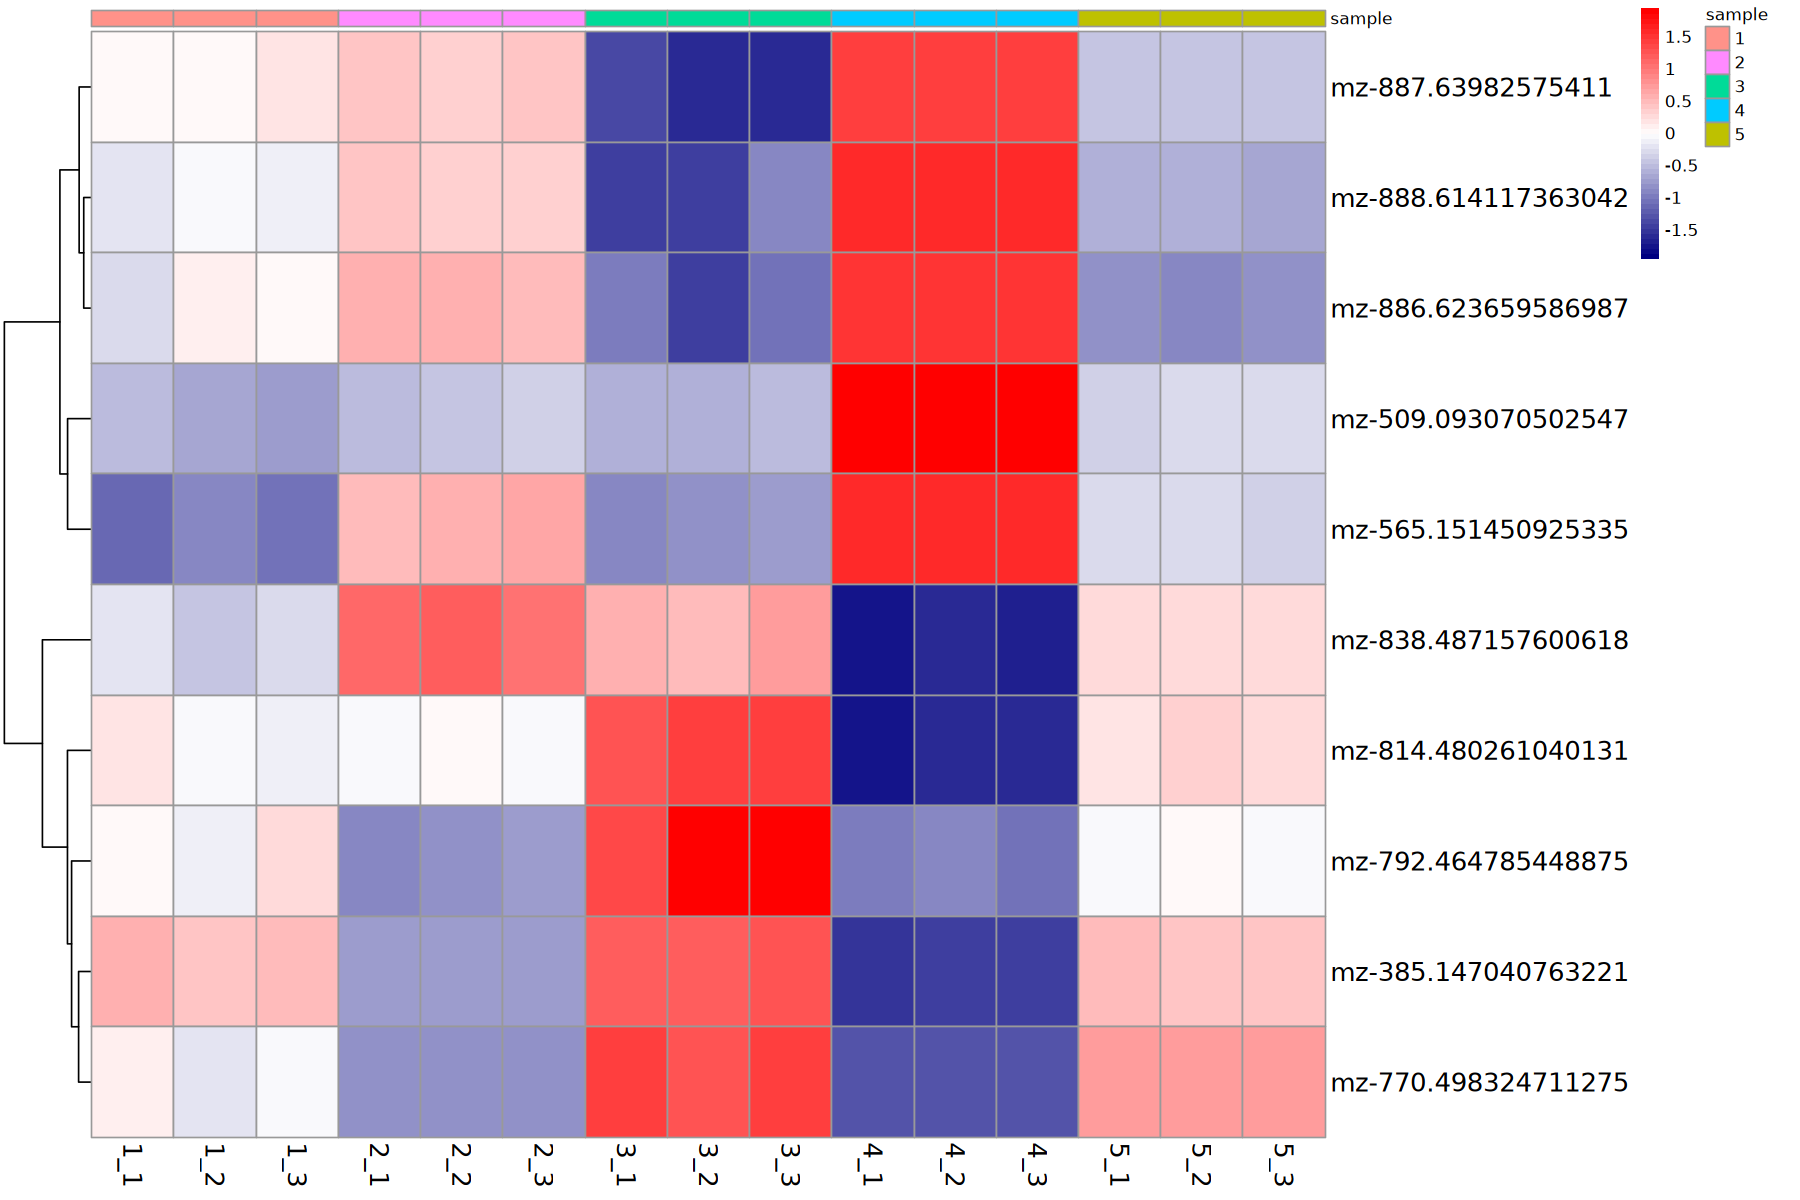

In [27]:
options(repr.plot.width = 15, repr.plot.height = 10) 
DEPsHeatmapX(edger, only.pos = T, order.by = "logFC")

In [30]:
library(fields)
library(Matrix)
library(dplyr)
library(rlist)
library(stringr)
library(fgsea)
library(pbapply)

#' @description
#' @param mass_matrix is a matrix like object with each row corresponding to a pixel, and each column corresponding to a m/z value (Colnames = m/z values), support sparse/dense matrix,m each cell is the intensity of at the pixel; Note that the mass matrix should be half-processed, which means not filtered against any background signals, but undergoes normalization and baseline correction
#' @param width is the width of each imaging dimension, in pixels
#' @param height is the height of each imaging dimension, in pixels
#' @param path is the output path for the visulisation.
#' @param ppm_error is the parts-per-million error tolerance of matching m/z value with potential metabolites
#' @param ion_mode is only needed when ppm_error is not specified, goes to function estimate_mz_resolution_error will be used to access the ppm_error
#' @param tof_resolution is the tof resolution of the instrument used for MALDI run, calculated by ion (ion mass,m/z)/(Full width at half height)
#' @param input_mz is used when mass_matrix doesn't have the column names to be the m/z value, it a list of m/z values with one-to-one correspondence with each column of the mass_matrix
#' @param num_retained_component is an integer value to indicated preferred number of PCs to retain
#' @param resampling_factor is a numerical value >0, indicate how you want to resample the size of roginal matrix
#' @param p_val_threshold is the p value threshold for pathways to be significant
#' @param byrow is a boolean to indicates whether each column of the matrix is built byrow or bycol.
#' @return pca is the pca information of original data
#' @return pathway_enrichment_pc is the pathway enrichment results for each PC

#' @example principal_component_pathway_analysis(mass_matrix = readRDS("~/mass_matrix.rds") [,1:150], 
#' width = 912,height = 853,ppm_error = NULL,ion_mode = "positive",tof_resolution = 30000,input_mz = NULL,num_retained_component = NULL,variance_explained_threshold = 0.9,resampling_factor = 2,p_val_threshold = 0.05)

# Which help to build a pathway db based on detected metabolites
get_analytes_db = function(input_id,analytehaspathway,
                           chem_props,pathway) {
  
  rampid = unique(chem_props$ramp_id[which(chem_props$chem_source_id %in% unique(input_id))])
  #
  pathway_ids = unique(analytehaspathway$pathwayRampId[which(analytehaspathway$rampId %in% rampid)])
  
  analytes_db = lapply(pathway_ids, function(x) {
    content = analytehaspathway$rampId[which(analytehaspathway$pathwayRampId == x)]
    content = content[which(grepl(content, pattern = "RAMP_C"))]
    return(content)
  })
  analytes_db_name = unlist(lapply(pathway_ids, function(x) {
    name = pathway$pathwayName[which(pathway$pathwayRampId == x)]
    return(name)
  }))
  names(analytes_db) = analytes_db_name
  return(analytes_db)
}


#Helper function list_to_pprcomp

# Which help to build a pathway db based on detected metabolites
list_to_pprcomp <- function(lst) {
  # Create an empty object with class pprcomp
  obj <- structure(list(), class = "prcomp")
  # Assign components from the list to the object
  obj$sdev <- lst$sdev
  obj$rotation <- lst$rotation
  obj$center <- lst$center
  obj$scale <- lst$scale
  obj$x <- lst$x
  # Add other components as needed
  
  # Return the constructed pprcomp object
  return(obj)
}

label_background = function(mass_matrix,
                            level){
  labelled = apply(mass_matrix, MARGIN =1, FUN = function(x){
    if(length(which(x==0))>=level*length(x)){
      return("Background")
    }else{
      return("Target")
    }
  })
}
find_index <- function(lst, value) {
  indices <- which(sapply(lst, function(x) value %in% x))
  if (length(indices) == 0) {
    return(NULL)  # If value not found, return NULL
  } else {
    return(indices)
  }
}
principal_component_pathway_analysis = function(mass_matrix,
                                                width,
                                                height,
                                                path = getwd(),
                                                ppm_error = NULL,
                                                ion_mode = NULL,
                                                tof_resolution = 30000,
                                                input_mz = NULL,
                                                num_retained_component = NULL,
                                                variance_explained_threshold = 0.9,
                                                resampling_factor = 2,
                                                p_val_threshold = 0.05,
                                                byrow = T) {
  # PCA analysis
  print("Scaling original matrix")
  mass_matrix = Matrix(as.matrix(mass_matrix), sparse = T)
  if (!is.null(resampling_factor)) {
    print("Running matrix resampling")
    pb = txtProgressBar(
      min = 0,
      max = ncol(mass_matrix),
      initial = 0,
      style = 3
    )
    if (!is.numeric(resampling_factor)) {
      stop("Please enter correct resampling_factor")
    }
    new.width = as.integer(width / resampling_factor)
    new.height = as.integer(height / resampling_factor)
    
    resampled_mat = matrix(nrow =  new.height * new.width)
    for (i in 1:ncol(mass_matrix)) {
      temp_mz_matrix = matrix(mass_matrix[, i],
                              ncol = width,
                              nrow = height,
                              byrow = byrow)
      resampled_temp = ResizeMat(temp_mz_matrix, c(new.width,
                                                   new.height))
      resampled_mat = cbind(resampled_mat, as.vector(resampled_temp))
      setTxtProgressBar(pb, i)
    }
    close(pb)
    resampled_mat = resampled_mat[,-1]
    colnames(resampled_mat) = colnames(mass_matrix)
    print("Resampling finished!")
    gc()
  }
  print("Running the principal component analysis (can take some time)")
  # Runing PCA
  
  resampled_mat_standardised = as.matrix(t(
    t(resampled_mat) - Matrix::colSums(resampled_mat) / nrow(resampled_mat)
  ))
  print("Computing the covariance")
  cov_mat <- cov(resampled_mat_standardised)
  print("Computing the eigenvalue/eigenvectors")
  eigen_result <- eigen(cov_mat)
  gc()
  # Extract eigenvectors and eigenvalues
  eigenvectors <- eigen_result$vectors
  eigenvalues <- eigen_result$values
  
  print("Computing PCA")
  pc = pbapply::pblapply(1:ncol(resampled_mat_standardised), function(i) {
    temp = resampled_mat_standardised[, 1] * eigenvectors[1, i]
    for (j in 2:ncol(resampled_mat_standardised)) {
      temp = temp + resampled_mat_standardised[, j] * eigenvectors[j, i]
    }
    return(temp)
  })
  pc = do.call(cbind, pc)
  colnames(pc) = paste0("PC", 1:ncol(eigenvectors))
  # make pca object
  colnames(eigenvectors) = paste0("PC", 1:ncol(eigenvectors))
  rownames(eigenvectors) = colnames(resampled_mat)
  pca = list(
    sdev = sqrt(eigenvalues),
    rotation = eigenvectors,
    center = Matrix::colSums(resampled_mat) / nrow(resampled_mat),
    scale = FALSE,
    x = pc
  )
  pca = list_to_pprcomp(pca)
  print("PCA finished")
  rm(mass_matrix)
  gc()
  eigenvalues = pca$sdev ^ 2
  # Step 5: Compute Principal Components
  # Choose number of principal components, k
  # if not input, use scree test to help find retained components
  
  if (is.null(num_retained_component)) {
    if (!is.null(variance_explained_threshold)) {
      tryCatch({
        cumulative_variance = cumsum(eigenvalues) / sum(eigenvalues)
        par(mfrow = c(1, 1))
        par(mar = c(2, 2, 1, 1))
        # Plot cumulative proportion of variance explained
        plot(
          cumulative_variance,
          type = 'b',
          main = "Cumulative Variance Explained",
          xlab = "Number of Principal Components",
          ylab = "Cumulative Proportion of Variance Explained"
        )
        
        # Add a horizontal line at the desired threshold
        threshold = variance_explained_threshold  # Example threshold
        abline(h = threshold,
               col = "red",
               lty = 2)
        
        # Find the number of principal components to retain based on the threshold
        retained =  which(cumulative_variance >= threshold)[1] - 1
      },
      error = function(cond) {
        stop(
          "Check if correct variance threshold for principle components are inputted, should be numeric value between 0 and 1"
        )
      },
      warning = function(cond) {
        stop(
          "Check if correct variance threshold for principle components are inputted, should be numeric value between 0 and 1"
        )
      })
      
    } else{
      # if threshold not inputted, use Kaiser's criterion
      print(
        "Both variance_explained_threshold and num_retained_component not inputted, use Kaiser's criterion for determination"
      )
      plot(
        eigenvalues,
        type = 'b',
        main = "Scree Plot",
        xlab = "Principal Component",
        ylab = "Eigenvalue"
      )
      
      # Add a horizontal line at 1 (Kaiser's criterion)
      abline(h = 1,
             col = "red",
             lty = 2)
      
      # Add a vertical line at the elbow point
      elbow_point <- which(diff(eigenvalues) < 0)[1]
      abline(v = elbow_point,
             col = "blue",
             lty = 2)
      retained = length(which(eigenvalues >= 1))
    }
  } else{
    retained = as.integer(num_retained_component)
    if (is.na(retained)) {
      stop("Please enter correct number of principle components to retain")
    }
  }
  
  if (!is.null(input_mz)) {
    if ((length(input_mz) != ncol(resampled_mat)) |
        (!is.numeric(input_mz))) {
      stop(
        "Please ensure input_mz has one-to-one correspondence with each column of the mass_matrix"
      )
    } else{
      input_mz = input_mz
    }
  } else{
    tryCatch({
      input_mz = data.frame(cbind(
        row_id = 1:length(colnames(resampled_mat)),
        mz = as.numeric(colnames(resampled_mat))
      ))
    },
    error = function(cond) {
      stop(
        "Check whether column names of the input matrix is correctly labelled as the m/z ratio"
      )
    },
    warning = function(cond) {
      stop(
        "Check whether column names of the input matrix is correctly labelled as the m/z ratio"
      )
    })
  }
  
  #
  source(paste0(dirname(system.file(package = "SpaMTP")), "/R/fct_db_adduct_filter.R"))
  source(paste0(dirname(system.file(package = "SpaMTP")), "/R/fct_formula_filter.R"))
  source(paste0(dirname(system.file(package = "SpaMTP")), "/R/fct_proc_db.R"))
  #### Load the Cleaned and summarized DB ####
  Chebi_db     = readRDS(paste0(dirname(system.file(package = "SpaMTP")), "/inst/db_files/Chebi_1_names.rds"))
  HMDB_db      = readRDS(paste0(dirname(system.file(package = "SpaMTP")), "/inst/db_files/HMDB_1_names.rds"))
  
  # Set the db that you want to search against
  db = rbind(HMDB_db, Chebi_db)
  # set which adducts you want to search for
  adduct_file = readRDS(paste0(dirname(system.file(package = "SpaMTP")), "/inst/adduct_file.rds"))
  if (is.null(ion_mode)) {
    stop("Please enter correct polarity:'positive' or 'negative'")
  } else{
    if (ion_mode == "positive") {
      test_add = sub(" ", "", adduct_file$adduct_name[which(adduct_file$charge >= 0)])
    } else if (ion_mode == "negative") {
      test_add = sub(" ", "", adduct_file$adduct_name[which(adduct_file$charge <= 0)])
    }
  }
  # Using Chris' pipeline for annotation
  # 1) Filter DB by adduct.
  db_1 = db_adduct_filter(db, test_add, polarity = ifelse(ion_mode == "positive",
                                                          "pos", "neg"))
  
  # 2) only select natural elements
  db_2 = formula_filter(db_1)
  
  # 3) search db against mz df return results
  # Need to specify ppm error
  # If ppm_error not specified, use function to estimate
  # Set error tolerance
  ppm_error = 1e6 / tof_resolution / sqrt(2 * log(2))
  db_3 = proc_db(input_mz, db_2, ppm_error) %>% mutate(entry = str_split(Isomers,
                                                                         pattern = "; "))
  print("Query necessary data and establish pathway database")
  input_id = lapply(db_3$entry, function(x) {
    x = unlist(x)
    index_hmdb = which(grepl(x, pattern = "HMDB"))
    x[index_hmdb] = paste0("hmdb:", x[index_hmdb])
    index_chebi = which(grepl(x, pattern = "CHEBI"))
    x[index_chebi] = tolower(x[index_chebi])
    return(x)
  })
  chem_props = readRDS(paste0(dirname(system.file(package = "SpaMTP")), "/data/chem_props.rds"))
  db_3 = db_3 %>% mutate(inputid = input_id)
  rampid = c()
  chem_source_id = unique(chem_props$chem_source_id)
  pb = txtProgressBar(
    min = 0,
    max = nrow(db_3),
    initial = 0,
    style = 3
  )
  for (i in 1:nrow(db_3)) {
    rampid[i] = (chem_props$ramp_id[which(chem_source_id %in% db_3$inputid[i][[1]])])[1]
    setTxtProgressBar(pb, i)
  }
  close(pb)
  db_3 = cbind(db_3, rampid)
  print("Query finished")
  ####################################################################################################
  
  # get rank pathway database
  print("Getting reference pathways")
  analytehaspathway = readRDS(paste0(dirname(system.file(package = "SpaMTP")), "/data/analytehaspathway.rds"))
  pathway = readRDS(paste0(dirname(system.file(package = "SpaMTP")), "/data/pathway.rds"))
  source = readRDS(paste0(dirname(system.file(package = "SpaMTP")), "/data/source.rds"))
  
  
  pathway_db = get_analytes_db(unlist(input_id), analytehaspathway,
                               chem_props, pathway)
  
  pathway_db = pathway_db[which(!duplicated(names(pathway_db)))]
  # get names for the ranks
  name_rank = lapply(input_mz$mz, function(x) {
    return(unique(na.omit(db_3$rampid[which(db_3$observed_mz == x)])))
  })
  
  #Set progress bar
  
  print("Runing set enrichment analysis")
  pca_sea_list = list()
  pb_new = txtProgressBar(
    min = 0,
    max = retained,
    initial = 0,
    style = 3
  )
  for (i in 1:retained) {
    # get the absolute value and sign of the loading
    loading = data.frame(cbind(
      abs_loading = abs(pca[["rotation"]][, i]),
      sign_loading = sign(pca[["rotation"]][, i])
    )) %>% arrange(desc(abs_loading))
    # run set enrichment analysis
    
    ranks = unlist(lapply(1:length(pca[["rotation"]][, i]), function(x) {
      pc_new = rep(pca[["rotation"]][x, i], times = length(name_rank[[x]])) +
        sample(-5:5, length(name_rank[[x]]), replace = T) * 1e-7
      names(pc_new) = name_rank[[x]]
      return(pc_new)
    }))
    ranks = ranks[which(!duplicated(names(ranks)))]
    suppressWarnings({
      gsea_result = fgsea::fgsea(
        pathways =  pathway_db,
        stats = ranks,
        minSize = 5,
        maxSize = 500
      ) %>% filter(pval <= p_val_threshold) %>% mutate(principle_component = paste0("PC", i)) %>% mutate(leadingEdge_metabolites = lapply(leadingEdge, function(x) {
        temp = unique(unlist(x))
        metabolites_name = c()
        for (z in 1:length(temp)) {
          index <- find_index(name_rank , temp[z])
          direction = sign(sum(pca[["rotation"]][index, i]))
          metabolites_name = c(metabolites_name,
                               paste0(
                                 tolower(chem_props$common_name[which(chem_props$ramp_id == temp[z])])[1],
                                 ifelse(direction >= 0, "↑", "↓")
                               ))
        }
        
        return(metabolites_name)
      }))
    })
    setTxtProgressBar(pb_new, i)
    # Make sure sign of loading is positive to make it positively correlate with the PC
    pca_sea_list = list.append(pca_sea_list,
                               gsea_result)
  }
  close(pb_new)
  names(pca_sea_list) = paste0("PC", 1:retained)
  
  ######################### Creating html
  image_matrix = matrix(
    rowSums(resampled_mat),
    ncol = new.width,
    nrow = new.height,
    byrow = T
  )
  image(image_matrix)
  # Assign different colours to different layers
  
  quantiles <-
    quantile(as.numeric(as.vector(image_matrix)), probs = seq(0, 1, 0.2))
  quantiles <-
    unique(quantiles + seq(0, 1e-10, length.out = length(quantiles)))
  col_index <-
    cut(as.vector(image_matrix),
        breaks = quantiles,
        labels = FALSE)
  
  library(jsonlite)
  colors <- c("red", "blue", "green", "yellow", "orange")
  
  # (1) Tissue image
  quantiles = quantile(as.numeric(as.vector(image_matrix)),
                       probs = seq(0, 1, 0.2))
  quantiles <-
    unique(quantiles + seq(0, 1e-10, length.out = length(quantiles)))
  
  col_index <-
    cut(t(image_matrix), breaks = quantiles, labels = FALSE)
  
  matrix_data_melted = reshape2::melt(t(image_matrix)) %>%
    mutate(color = col_index)
  
  matrix_data_melted = matrix_data_melted %>% rowwise() %>% mutate(col_nam  = colors[color])
  
  index = which(matrix_data_melted$value != 0)
  
  matrix_data_melted = matrix_data_melted[index, ]
  tissue_image <- list(
    y = matrix_data_melted$Var1,
    x = matrix_data_melted$Var2,
    value = matrix_data_melted$value,
    colour = matrix_data_melted$col_nam,
    width = new.width,
    height = new.height
  )
  
  
  #a = reshape2::melt(c(1: nrow(pca$x)))
  # Convert to JSON
  
  # Optionally, write to a file

  
  
  #PCA_result
  # Convert list to JSON
  # Extract relevant components
  num = 5
  prcomp_data <- list(
    rotation = t(pca$rotation[, 1:num]),
    center = pca$center,
    scale = pca$scale,
    sdev = pca$sdev,
    x = t(pca$x[index, 1:num]),
    mz = rownames(pca[["rotation"]]),
    coordinate = t(cbind(
      rep(1:new.height,
          each = new.width),
      rep(1:new.width,
          times = new.height)
    )[index]),
    name =  sprintf(
      "(%d,%d)",
      rep(1:new.height,
          each = new.width),
      rep(1:new.width,
          times = new.height)
    )[index]
  )
  
  ################### GSEA results
  var_gsea_table = c()
  for (i in 1:num) {
    temp = pca_sea_list[[i]]
    if (nrow(temp) == 0) {
      empty_row = t(c("No Signifcant Pathway Found",
                      rep(NA, times = ncol(temp) - 1)))
      temp = rbind(temp, empty_row, use.names = FALSE)
    }
    metabolites = c()
    if (nrow(temp) == 0) {
      var_gsea_table = c(var_gsea_table,
                         paste0('var PC', i, '=[', paste(rep('[],', times = 4),
                                                         collapse = ""), "]"))
      next
    }
    for (j in 1:length(temp$leadingEdge_metabolites)) {
      metabolites = c(metabolites,
                      paste0(unique(temp$leadingEdge_metabolites[[j]]), collapse = ", "))
    }
    temp_table = cbind(temp[, 1:7], metabolites = metabolites)
    var_gsea_table = c(
      var_gsea_table,
      paste0(
        'var PC',
        i,
        '=[',
        toJSON(temp_table$pathway),
        ',',
        toJSON(temp_table$pval),
        ',',
        toJSON(temp_table$NES),
        ',',
        toJSON(temp_table$metabolites),
        ']',
        collapse = ""
      )
    )
  }
  
  
  json_data <- jsonlite::toJSON(prcomp_data)
  json_matrix_data <- jsonlite::toJSON(tissue_image)
  
  html_temp = paste0(
    '<!DOCTYPE html>
  <html lang="en">
  <head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
  <script src="gmm_class.js"></script>
  <script src="kmeans.js"></script>
  <title>Prcomp Visualization</title>
  <style>
    .container {
      display: flex;
      justify-content: start; /* Optional: Adjust as needed */
    }
    .box {
      border: 1px solid black; /* Optional: Add borders for visibility */
      position: relative;
    }

    .input-container {
            display: inline-block;
        }

        /* Optional styling for label */
        label {
            margin-right: 5px; /* Adjust spacing between label and input */
        }
        .red-text {
    color: red;
    position: absolute;
    top: 0;
    left: 0;
}
  </style>
  </head>
  <body>
  <h1>Prcomp Data</h1>
  <div class="input-container"></div>
  <label>x-axis selection
    <select id="xSelect">
        <option value="" disabled selected>Select your PC</option>
        <option value="PC1" selected="selected">PC1</option>
        <option value="PC2">PC2</option>
        <option value="PC3">PC3</option>
        <option value="PC4">PC4</option>
        <option value="PC5">PC5</option>
    </select>
    </label>
    <label>y-axis selection
      <select id="ySelect">
          <option value="" disabled selected>Select your PC</option>
          <option value="PC1">PC1</option>
          <option value="PC2"selected="selected">PC2</option>
          <option value="PC3">PC3</option>
          <option value="PC4">PC4</option>
          <option value="PC5">PC5</option>
      </select>
      </label>
      <label for="integerInput">Enter an Integer for Cluster Numbers:</label>
      <input type="number" id="numcluster" name="integerInput" step="1" min = "2"> 
      <label>Clustering method
        <select id="clustering">
            <option value="" disabled selected>Select clustering method</option>
            <option value="GMM">GMM</option>
            <option value="Kmean">Kmean</option>
        </select>
        <button type="button" id= "button1">Regenerate Clusters</button>
        </label>
      </div>
    <div id = "Warning" class = "red-text"> </div>
    <div class="container">
      <div>
        <div id="pcaPlot" class="box" style="width: 600px; height: 400px;">
        </div>
        <div class="box" id="plot" style="position: relative;width: 600px; height: 400px;z-index: 2;">
          <canvas id="rasterCanvas" style="position: absolute; top: 0; left: 0;width: 100%; height: 99%;z-index: 0;"></canvas>
          <canvas id="pointCanvas" style="position: absolute; top: 0; left: 0;width: 100%; height: 99%;z-index: 1;"></canvas>
        </div>
      </div>
      <div>
        <div id="table1" class="box" style="width: 600px; height: 400px;"></div>
        <div class="box" id="table2" style="width: 600px; height: 400px;"></div>
      </div>
    </div>

  <script>


  // Embed the JSON data directly \n',
    paste0(var_gsea_table, collapse = "\n")
    ,
    '
const prcompData = [',
    json_data ,
    '];
const matrixData = [',
    json_matrix_data,
    '];
// Example of using the data
// Example of using the data
//PCA plot

 var data_table1 = [{
  type: "table",
  header: {
    values: [["<b>Pathway</b>"], ["<b>p_value</b>"],
				 ["<b>NES</b>"], ["<b>metabolites</b>"]],
    align: "center",
    line: {width: 1, color: "black"},
    fill: {color: "grey"},
    font: {family: "Arial", size: 12, color: "white"}
  },
  cells: {
    values: PC1,
    align: "center",
    line: {color: "black", width: 1},
    font: {family: "Arial", size: 11, color: ["black"]}
  }
}]

var layout_table1 = {
  title: "PC1 Pathway Information"
}

Plotly.newPlot("table1", data_table1, layout_table1);

// Table 2
var data_table2  = [{
  type: "table",
  header: {
    values: [["<b>Pathway</b>"], ["<b>p_value</b>"],
				 ["<b>NES</b>"], ["<b>metabolites</b>"]],
    align: "center",
    line: {width: 1, color: "black"},
    fill: {color: "grey"},
    font: {family: "Arial", size: 12, color: "white"}
  },
  cells: {
    values: PC2,
    align: "center",
    line: {color: "black", width: 1},
    font: {family: "Arial", size: 11, color: ["black"]}
  }
}]
var layout_table2 = {
  title: "PC2 Pathway Information"
}
Plotly.newPlot("table2", data_table2 ,layout_table2);


// pca PLOT
// Function to initialize parameters of GMM


function createArray(length) {
    // Calculate the value that each slot should hold
    const slotValue = 1 / length;

    // Create an array and populate it with the calculated value
    const array = Array(length).fill(slotValue);

    // Adjust the last element to ensure the sum equals 1
    array[length - 1] += 1 - array.reduce((sum, value) => sum + value, 0);

    return array;
}
function generateColors(n) {
    const colors = [];
    const increment = 360 / n;

    for (let i = 0; i < n; i++) {
        const hue = Math.round(increment * i);
        const saturation = 70; // You can adjust this value if needed
        const lightness = 70; // You can adjust this value if needed
        const color = `hsl(${hue}, ${saturation}%, ${lightness}%)`;
        colors.push(color);
    }

    return colors;
}
function transpose(array) {
    if (array.length === 0 || !Array.isArray(array[0])) return [];

    // Create an array to hold the result with the same number of sub-arrays as there are elements in each sub-array
    let result = [];
    for (let i = 0; i < array[0].length; i++) {
        result[i] = [];
        for (let j = 0; j < array.length; j++) {
            result[i].push(array[j][i]);
        }
    }

    return result;
}


// Assuming your data structure is stored in a variable called data_structure
var xCoordinates = matrixData[0].x;
var yCoordinates = matrixData[0].y;
var colors = matrixData[0].colour;
var value = matrixData[0].value
const canvas = document.getElementById("rasterCanvas");
const ctx = canvas.getContext("2d");
const container_tissue = document.getElementById("plot");
canvas.width = container_tissue.offsetWidth;
canvas.height = container_tissue.offsetHeight;
        // Calculate scaling factors
const scaleX = canvas.width/matrixData[0].height/1.1; // Assuming original width is 600
const scaleY = canvas.height/matrixData[0].width/1.1;
// draw raster image
  // Set canvas size


for (var i = 0; i < xCoordinates.length; i++) {
  //
            // Convert coordinates to canvas coordinates
            var canvasX = xCoordinates[i] * scaleX;
            var canvasY = yCoordinates[i] * scaleY;
            // Draw point
            ctx.fillStyle = colors[i];
            ctx.fillRect(canvasX, canvasY, 1, 1);
        }

function byRowToArrayByColumn(arr, numRows, numCols) {
    const result = [];
    for (let col = 0; col < numCols; col++) {
        for (let row = 0; row < numRows; row++) {
            result.push(arr[row * numCols + col]);
        }
    }
    return result;
}
function transposeArray(array) {
    return array[0].map((_, colIndex) => array.map(row => row[colIndex]));
}
var pc = [PC1,PC2,PC3,PC4,PC5]
console.log(pc)
function updatepcaPlot() {
  var num_to_cluster = Number(document.getElementById("numcluster").value)
  console.log(num_to_cluster)
  var candidate = ["PC1","PC2","PC3","PC4","PC5"]
  var xValue = document.getElementById("xSelect").value;
  var yValue = document.getElementById("ySelect").value;
  var new_pc1_index = candidate.findIndex(num => num === xValue)
  var new_pc2_index = candidate.findIndex(num => num === yValue)
  var method = document.getElementById("clustering").value;
  var pca_input = prcompData[0].x[new_pc1_index].map((element, index) => [element, prcompData[0].x[new_pc2_index][index]])
  //var pca_input = prcompData[0].x[0].map((element, index) => [element, prcompData[0].x[1][index]])


  //console.log(kmean_result)
  //console.log(kmean_result.centroids)

  let xMax = pca_input.reduce((max, subarray) => Math.max(max, subarray[0]), -Infinity);
  let yMax = pca_input.reduce((max, subarray) => Math.max(max, subarray[1]), -Infinity);
  let xMin = pca_input.reduce((min, subarray) => Math.min(min, subarray[0]), Infinity);
  let yMin = pca_input.reduce((min, subarray) => Math.min(min, subarray[1]), Infinity);
  let dx = xMax-xMin;
	let dy = yMax-yMin;
	let covariances = Array(num_to_cluster).fill(0)
		.map(_ => [[dx*dx*.01, 0], [0, dy*dy*.01]]);
  let colors = generateColors(num_to_cluster)
  if(method === "GMM"){
    let gmm = new GMM({
	  weights: Array(num_to_cluster).fill(1/num_to_cluster),
	  means: Array(num_to_cluster).fill(0).map(_ => [xMin + Math.random()*dx, yMin + Math.random()*dy]),
	  covariances: covariances
});
  //console.log(pca_input)
  pca_input.forEach(p => gmm.addPoint(p));
  gmm.runEM(10);
  let assignments = []

  for (let i = 0; i < pca_input.length; i++) {
    let probNorm = gmm.predictNormalize(pca_input[i]);
    let index = probNorm.indexOf(Math.max(...probNorm));
    assignments.push(colors[index])
    // Do something with probNorm if needed
 }
  //console.log(assignments)
  //prcompData[0].x[0].map((element, index) => [element, prcompData[0].x[1][index]])
  var update_pca = {
    "marker.color": [assignments]
  };
  //const canvas = document.querySelector("cycles_canvas");
  //const draw = new Draw(canvas, xMin, xMax, yMin, yMax);
  Plotly.restyle("pcaPlot", update_pca, 0);
  //for(let i=0; i<gmm.clusters; i++) {
	//		draw.ellipse(gmm.means[i], gmm.covariances[i], clusterColors[i]);
	//	}

  // update colours
  //console.log(assignments)
  ctx.clearRect(0, 0, canvas.width, canvas.height);
  //let new_colour = assignments
  for (var i = 0; i < yCoordinates.length; i++) {
  //
            // Convert coordinates to canvas coordinates
            var canvasX = xCoordinates[i] * scaleX;
            var canvasY = yCoordinates[i] * scaleY;
            // Draw point
            ctx.fillStyle = assignments[i];
            ctx.fillRect(canvasX, canvasY, 1, 1);
        }

  }else if(method === "Kmean"){
    let assignments = []
    let kmean_result = kmeans(pca_input, num_to_cluster)
    console.log(kmean_result)
    for (let i = 0; i < pca_input.length; i++) {
    assignments.push(colors[kmean_result[1][i]])
    // Do something with probNorm if needed
 }
    // Do something with probNorm if needed
    //console.log(assignments)

 var update_pca = {
    "marker.color": [assignments]
  };
  //const canvas = document.querySelector("cycles_canvas");
  //const draw = new Draw(canvas, xMin, xMax, yMin, yMax);
  Plotly.restyle("pcaPlot", update_pca, 0);

  ctx.clearRect(0, 0, canvas.width, canvas.height);

  for (var i = 0; i < yCoordinates.length; i++) {
  //
            // Convert coordinates to canvas coordinates
            var canvasX = xCoordinates[i] * scaleX;
            var canvasY = yCoordinates[i] * scaleY;
            // Draw point
            ctx.fillStyle = assignments[i];
            ctx.fillRect(canvasX, canvasY, 1, 1);
        }
  }
}
document.getElementById("clustering").addEventListener("change", updatepcaPlot);
var button = document.getElementById("button1")

button.onclick = function(){
  updatepcaPlot();
}
  // Simulated PCA data (you would use your actual PCA data here)
  var pcaData = {
    names: prcompData[0].name,
    pc1: prcompData[0].x[0],
    pc2: prcompData[0].x[1]
  };

  var trace1pc = {
    x: pcaData.pc1,
    y: pcaData.pc2,
    mode: "markers",
    type: "scatter",
    marker: { size: 0.3 },
    text: pcaData.names,
    hoverinfo: "text+x+y"
  };

  var data_pc = [trace1pc];

  var layout_pc = {
    title: "PCA Plot",
    xaxis: { title: "PC1" },
    yaxis: { title: "PC2" },
    width: 600,
    height: 400
  };

  Plotly.newPlot("pcaPlot", data_pc, layout_pc);

  function updatePlot() {
      var candidate = ["PC1","PC2","PC3","PC4","PC5"]
      var xValue = document.getElementById("xSelect").value;
      var yValue = document.getElementById("ySelect").value;

      var new_pc1_index = candidate.findIndex(num => num === xValue)
      var new_pc2_index = candidate.findIndex(num => num === yValue)
      var pcaData = {
        names: prcompData[0].name,
        pc1: prcompData[0].x[new_pc1_index],
        pc2: prcompData[0].x[new_pc2_index]
      };

      var trace1pc = {
        x: pcaData.pc1,
        y: pcaData.pc2,
        mode: "markers",
        type: "scatter",
        marker: { size: 0.3 },
        text: pcaData.names,
        hoverinfo: "text+x+y"
      };
      var layout_pc = {
      title: "PCA Plot",
      xaxis: { title: candidate[new_pc1_index] },
      yaxis: { title: candidate[new_pc2_index] },
      width: 600,
      height: 400
     };
      var data_pc = [trace1pc];

      Plotly.newPlot("pcaPlot", data_pc, layout_pc);
    // Update table with new content
    var data_table1_new = [{
  type: "table",
  header: {
    values: [["<b>Pathway</b>"], ["<b>p_value</b>"],
				 ["<b>NES</b>"], ["<b>metabolites</b>"]],
    align: "center",
    line: {width: 1, color: "black"},
    fill: {color: "grey"},
    font: {family: "Arial", size: 12, color: "white"}
  },
  cells: {
    values: pc[new_pc1_index],
    align: "center",
    line: {color: "black", width: 1},
    font: {family: "Arial", size: 11, color: ["black"]}
  }
}]

var layout_table1_new = {
  title: "PC"+(new_pc1_index+1)+" Pathway Information"
}

Plotly.react("table1", data_table1_new, layout_table1_new);
Plotly.relayout("table1", layout_table1_new);
// Table 2
var data_table2_new  = [{
  type: "table",
  header: {
    values: [["<b>Pathway</b>"], ["<b>p_value</b>"],
				 ["<b>NES</b>"], ["<b>metabolites</b>"]],
    align: "center",
    line: {width: 1, color: "black"},
    fill: {color: "grey"},
    font: {family: "Arial", size: 12, color: "white"}
  },
  cells: {
    values: pc[new_pc2_index],
    align: "center",
    line: {color: "black", width: 1},
    font: {family: "Arial", size: 11, color: ["black"]}
  }
}]
var layout_table2_new = {
  title: "PC"+(new_pc2_index+1)+" Pathway Information"
}
Plotly.react("table2", data_table2_new ,layout_table2_new);
Plotly.relayout("table2", layout_table2_new);

document.getElementById("pcaPlot").on("plotly_hover", function(data){
    // Get index of clicked point
    var pointIndex = data.points[0].pointIndex;
    // console.log(pointIndex)
    let x_new_scatter = xCoordinates[pointIndex]*scaleX
    let y_new_scatter = yCoordinates[pointIndex]*scaleY

        ctx2.clearRect(0, 0, canvas2.width, canvas2.height);

        // Draw new point
        ctx2.fillStyle = "red";  // Color of the new point
        ctx2.beginPath();
        ctx2.arc(x_new_scatter, y_new_scatter , 3, 0, Math.PI * 2, true);  // Small circle for the point
        console.log(x_new_scatter)
        ctx2.fill();
        // Update last point coordinates
        lastX = x_new_scatter;
        lastY = y_new_scatter;
});
}



    // Event listeners to update the plot when selections change
    document.getElementById("xSelect").addEventListener("change", updatePlot);
    document.getElementById("ySelect").addEventListener("change", updatePlot);
    document.getElementById("clustering").addEventListener("change", updatepcaPlot);

// Example of using the data
console.log(prcompData[0].rotation[0]);






  // Plot each pixel

  // let xCoords = Array.from({length: 100}, (_, i) => 2*i);
  // let yCoords = Array.from({length: 100}, (_, i) => i);
  // let colors2 = new Array(10000).fill().map(() => `rgb(${Math.random()*255}, ${Math.random()*255}, ${Math.random()*255})`);

  // // Set canvas size
  // canvas.width = 100;
  // canvas.height = 100;
  // for (let x = 0; x < xCoords.length; x++) {
  //     for (let y = 0; y < yCoords.length; y++) {
  //         // Index for the colors array
  //         let index = x * yCoords.length + y;
  //         ctx.fillStyle = colors2[index];
  //         ctx.fillRect(xCoords[x], yCoords[y], 1, 1);
  //     }
  // }
// Create a trace for the heatmap
var trace = {
  y: xCoordinates,
  x: yCoordinates,
  z: value,
  mode: "markers",
  type: "heatmap",
  color: colors,
  //marker: {
  //  color:colors,
  //  size: 0.2
  //},
  //colorscale: "Viridis"
};

let lastX = null;
let lastY = null;
const canvas2 = document.getElementById("pointCanvas");
const ctx2 = canvas2.getContext("2d");
canvas2.width = container_tissue.offsetWidth;
canvas2.height = container_tissue.offsetHeight;
// Create the plot

//Plotly.newPlot("plot", [trace,trace_heatmap_scatter], layout,{staticPlot: true});
document.getElementById("pcaPlot").on("plotly_hover", function(data){
    // Get index of clicked point
    var pointIndex = data.points[0].pointIndex;
    // console.log(pointIndex)
    let x_new_scatter = xCoordinates[pointIndex]*scaleX
    let y_new_scatter = yCoordinates[pointIndex]*scaleY

        ctx2.clearRect(0, 0, canvas2.width, canvas2.height);

        // Draw new point
        ctx2.fillStyle = "yellow";  // Color of the new point
        ctx2.beginPath();
        ctx2.arc(x_new_scatter, y_new_scatter , 3, 0, Math.PI * 2, true);  // Small circle for the point
        console.log(x_new_scatter)
        ctx2.fill();
        // Update last point coordinates
        lastX = x_new_scatter;
        lastY = y_new_scatter;
});

document.addEventListener("DOMContentLoaded", function() {
    var divElement = document.getElementById("Warning");
    var newText = document.createElement("span"); // Creates a new <span> element
    newText.className = "Warning"; // Assigns the class for styling
    newText.textContent = "Note that ↑ and ↓ of PC pathway information are the sign of the loading corresponds to the metabolites m/z, since the sign is abitarily assigned during PCA depends on the setting, the arrow is only comparable within each PC and do not have biological implications, they are just used to describe how the metabolite contribute the PC"; // Adds text

    divElement.style.position = "relative"; // Ensures that the div can hold absolute positioned elements
    divElement.appendChild(newText); // Adds the newly created <span> to the div
});


</script>
</body>
</html>')
  setwd(path)
  gmm = readLines(paste0(dirname(system.file(package = "SpaMTP")), "/data/gmm_class.js"))
  writeLines(gmm,"gmm_class.js")
  kmean = readLines(paste0(dirname(system.file(package = "SpaMTP")), "/data/kmeans.js"))
  writeLines(kmean,"kmeans.js")
  
  writeLines(html_temp,"pca_analysis.html")
  return(list(pca = pca,
                pathway_enrichment_pc = pca_sea_list,
                new.width = as.integer(width/as.numeric(resampling_factor)),
                new.height = as.integer(height/as.numeric(resampling_factor))))
}




Attaching package: ‘rlist’


The following object is masked from ‘package:S4Vectors’:

    List




In [35]:
principal_component_pathway_analysis(pig_SpaMTP@assays$Spatial$counts, height = 110, width = 4959)

[1] "Scaling original matrix"
[1] "Running matrix resampling"
  |                                                                      |   0%

ERROR: Error in ResizeMat(temp_mz_matrix, c(new.width, new.height)): could not find function "ResizeMat"


In [26]:
library(dplyr) 

DEPsHeatmapX <- function(edgeR_output,
                        only.pos = FALSE,
                        n = 5,
                        FDR.threshold = 0.05,
                        logfc.threshold = 0.5,
                        order.by = "FDR",
                        scale ="row",
                        color = grDevices::colorRampPalette(c("navy", "white", "red"))(50),
                        cluster_cols = F,
                        cluster_rows = T,
                        fontsize_row = 15,
                        fontsize_col = 15,
                        cutree_cols = 9,
                        silent = TRUE,
                        plot_annotations_column = NULL,
                        save_to_path = NULL,
                        plot.save.width = 20,
                        plot.save.height = 20,
                        nlabels.to.show = NULL){


    degs <- edgeR_output$DEPs
    degs <- subset(degs, FDR < FDR.threshold)

    if (order.by == "FDR"){
        
        grouped_pos<- degs %>%
          group_by(cluster) %>%
          filter( logFC > logfc.threshold) %>%
          arrange(desc(regulate)) %>%
           slice_head(n = n)

        
        if (only.pos) {
            grouped_neg <- NULL
            
        } else {
            grouped_neg <- degs %>%
              group_by(cluster) %>%
              filter(logFC < - logfc.threshold) %>%
              arrange(regulate) %>%
              slice_head(n = n)
        }
        df <- do.call(rbind, list(grouped_pos,grouped_neg))
        df <- df[order(df$cluster, desc(df$regulate)), ]        
        
    } else {
        if ( order.by != "logFC"){
            warning("order.by has invalid argument. Must be either 'FDR' or 'logFC'. Heatmap defaulting to order by logFC")
        }

        grouped_pos<- degs %>%
              group_by(cluster) %>%
              filter(logFC > logfc.threshold) %>%
              arrange(-logFC) %>%
               slice_head(n = n)
        

        if (only.pos) {
            grouped_neg <- NULL
        } else {
            grouped_neg <- degs %>%
              group_by(cluster) %>%
              filter(logFC < - logfc.threshold) %>%
              arrange(logFC) %>%
              slice_head(n = n)
        }
        df <- do.call(rbind, list(grouped_pos,grouped_neg))
        df <- df[order(df$cluster, -df$logFC), ]
    }

    

  col_annot <- data.frame(sample = edgeR_output$samples$ident)
  row.names(col_annot) <- colnames(as.data.frame(edgeR::cpm(edgeR_output,log=TRUE)))

  mtx <- as.matrix(as.data.frame(edgeR::cpm(edgeR_output,log=TRUE))[unique(df$gene),])
  if (!(is.null(plot_annotations_column))){
    if (is.null(edgeR_output$DEPs[[plot_annotations_column]])){
      warning("There are no annotations present in the edgeR_output object. Run 'annotate.SeuratMALDI()' prior to 'FindAllDEPs' and set annotations = TRUE .....\n Heatmap will plot default m/z values ... ")
    } else{
      if (!is.null(nlabels.to.show)){
        def[[plot_annotations_column]] <- labels_to_show(df[[plot_annotations_column]], n = nlabels.to.show)
      }
      rownames(mtx) <- df[[plot_annotations_column]]
    }
  }

  p <- pheatmap::pheatmap(mtx,scale=scale,color=color,cluster_cols = cluster_cols, annotation_col=col_annot, cluster_rows = cluster_rows,
                fontsize_row = fontsize_row, fontsize_col = fontsize_col, cutree_cols = cutree_cols, silent = silent)

  # if (!(is.null(save_to_path))){
  #   save_pheatmap_as_pdf(pheatmap = p, filename = save_to_path, width = plot.save.width, height = plot.save.height)
  # }

  return(p)
}


Attaching package: ‘dplyr’


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:Hmisc’:

    src, summarize


The following objects are masked from ‘package:Cardinal’:

    combine, slice


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:EBImage’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.9 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /home/uqacause/conda_env/.conda/envs/r-env/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Australia/Brisbane
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggplot2_3.5.1            SpaMTP_0.0.0.9000        Seurat_5.1.0            
 [4] SeuratObject_5.0.2       sp_2.1-4                 CardinalWorkflows_1.34.0
 [7] Cardinal_3.2.1     